In [76]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties
from source.utils.metrics import auroc, aupr, fpr_at_tpr_x

os.makedirs(PLOTS_PATH, exist_ok=True)

In [77]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin"]
n_classes = [10, 100, 10, 200]
models = ["resnet18", "densenet169", "regnet"]

id = 0                                      # select dataset
method = methods[0]                         # select method 
metric = [auroc, aupr, fpr_at_tpr_x][0]     # select metric

p_drop = 0.2                                # dropout rate of MC dropout     

model = models[0]                           # select model
runs = 5                                    # number of runs

# select id dataset
dataset_name = dataset_names[id]    
# infer number of classes from dataset
n_class = n_classes[dataset_names.index(dataset_name)]

print(dataset_name, method, model, metric.__name__)

cifar10 deep_ensemble resnet18 auroc


In [78]:
if method == "deep_ensemble":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
elif method == "laplace":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
elif method == "mc_dropout":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

probits = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
probits = probits.reshape(len(probits), runs, -1, n_class)
y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))

uncertainties = calculate_uncertainties(probits, probits)

print(probits.shape)

torch.Size([10000, 5, 10, 10])


In [79]:
unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
components = ["TU", "AU", "EU"]

def evaluate(preds, uncertainties, metric, runs, dataset_name):
    
    print("Unc. ", end="")
    for unc_name in unc_names:
        print(f"& {unc_name} ", end="")
    print(" \\\\")
    print(f"\\hline & \\multicolumn{'{9}{c}{'}{dataset_name.upper()}{'}'} \\\\ \\cline{'{2-10}'} ")

    for c, comp in enumerate(components):
        print(f"{comp} ", end="")
        for measure in unc_names:
            scores = uncertainties[measure][c]
            perfs = list()
            for r in range(runs):
                ys = torch.ones(size=(len(probits), ), dtype=torch.long)
                ys = y_test != preds[:, r]
                # print(f"{1 - torch.mean(ys.float()).item():.4f}")
                perfs.append(metric(scores[:, r], ys).item() * 100)
            mean_str = f"{np.mean(perfs):.2f}".lstrip('0')
            std_str = f"{np.std(perfs):.2f}".lstrip('0')
            print(f"& ${mean_str}_{'{'}\pm {std_str}{'}'}$ ", end="")
        print(" \\\\")

### Predict with a single model

In [80]:
preds = torch.argmax(probits[:, :, 0], dim=-1)
evaluate(preds, uncertainties, metric, runs, dataset_name)

Unc. & A1 & A2 & A3 & B1 & B2 & B3 & C1 & C2 & C3  \\
\hline & \multicolumn{9}{c}{CIFAR10} \\ \cline{2-10} 
TU & $93.43_{\pm .20}$ & $94.81_{\pm .18}$ & $94.93_{\pm .17}$ & $94.55_{\pm .18}$ & $94.97_{\pm .11}$ & $94.92_{\pm .14}$ & $94.55_{\pm .18}$ & $94.97_{\pm .11}$ & $94.92_{\pm .14}$  \\
AU & $91.60_{\pm .37}$ & $91.60_{\pm .37}$ & $91.60_{\pm .37}$ & $94.97_{\pm .11}$ & $94.97_{\pm .11}$ & $94.97_{\pm .11}$ & $94.48_{\pm .09}$ & $94.48_{\pm .09}$ & $94.48_{\pm .09}$  \\
EU & $92.71_{\pm .34}$ & $94.50_{\pm .19}$ & $95.31_{\pm .12}$ & $92.86_{\pm .28}$ & $50.00_{\pm .00}$ & $94.56_{\pm .19}$ & $94.14_{\pm .22}$ & $94.81_{\pm .16}$ & $94.66_{\pm .18}$  \\


### Predict with the average model

In [81]:
preds = torch.argmax(torch.mean(probits, dim=2), dim=-1)
evaluate(preds, uncertainties, metric, runs, dataset_name)

Unc. & A1 & A2 & A3 & B1 & B2 & B3 & C1 & C2 & C3  \\
\hline & \multicolumn{9}{c}{CIFAR10} \\ \cline{2-10} 
TU & $90.93_{\pm .52}$ & $92.33_{\pm .39}$ & $92.40_{\pm .40}$ & $93.36_{\pm .18}$ & $93.83_{\pm .11}$ & $93.65_{\pm .16}$ & $93.36_{\pm .18}$ & $93.83_{\pm .11}$ & $93.65_{\pm .16}$  \\
AU & $89.16_{\pm .74}$ & $89.16_{\pm .74}$ & $89.16_{\pm .74}$ & $93.83_{\pm .11}$ & $93.83_{\pm .11}$ & $93.83_{\pm .11}$ & $93.57_{\pm .07}$ & $93.57_{\pm .07}$ & $93.57_{\pm .07}$  \\
EU & $90.24_{\pm .60}$ & $92.17_{\pm .25}$ & $92.94_{\pm .26}$ & $91.61_{\pm .34}$ & $50.00_{\pm .00}$ & $93.21_{\pm .19}$ & $92.85_{\pm .21}$ & $93.49_{\pm .20}$ & $93.31_{\pm .19}$  \\


In [82]:
probits = list()
y_tests = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))
    y_tests.append(y_test)
    probits.append(p)
    print(probits[-1].shape)

uncertainties = list()

for d, ds_probits in enumerate(probits):
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 100])


torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 200])


In [83]:
def evaluate_all(preds, y_tests, uncertainties, metric, runs):

    all_perfs = list()

    for i in range(len(dataset_names)):
        for c, comp in enumerate(components):
            for measure in unc_names:
                if comp == "EU" and measure == "B2":
                    continue # B2 is not defined for epistemic uncertainty
                scores = uncertainties[i][measure][c]
                for r in range(runs):
                    ys = torch.ones(size=(len(preds[i]), ), dtype=torch.long)
                    ys = y_tests[i] != preds[i][:, r]
                    all_perfs.append(metric(scores[:, r], ys).item() * 100)

    return torch.tensor(all_perfs).reshape(len(dataset_names), (len(components) * len(unc_names)) - 1, runs)

In [84]:
def plot(data, title, name:str = None):

    # original palette
    tu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#DD8452", "#CC6333"]
    au_colors = ["#5D8CD8", "#DD8452", "#55A868"]
    eu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#CC6333", "#85BF91", "#55A868", "#418050"]


    # tu_colors = au_colors = eu_colors = sns.color_palette("deep")


    tu_labels = ["A1", "A2", "A3", "B/C1", "B/C2", "B/C3"]
    au_labels = ["A", "B", "C"]
    eu_labels = ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"]

    # Create a figure
    # fig, axs = plt.figure(figsize=(12, 3.2)), list()
    fig, axs = plt.figure(figsize=(8, 3.2)), list()

    # Create a GridSpec with 1 row and 3 columns, and specify relative widths
    gs = gridspec.GridSpec(1, 3, width_ratios=[6.25, 3.25, 8.25])

    # Create subplots in the specified grid locations
    axs.append(fig.add_subplot(gs[0]))
    axs.append(fig.add_subplot(gs[1], sharey=axs[-1]))
    axs.append(fig.add_subplot(gs[2], sharey=axs[-1]))

    for i in range(len(tu_labels)):
        b = axs[0].bar(tu_labels[i], data[i].mean(), yerr=data[i].std(), color=tu_colors[i], label=tu_labels[i], linewidth=0)
        # if i >= 3:
        #     axs[0].bar(i + b[0].get_width() / 4, data[i].mean(), color=eu_colors[2 + i], linewidth=0, width=b[0].get_width() / 2)
    axs[0].set_xlabel("TU")

    for i in range(len(au_labels)):
        tl = 9
        axs[1].bar(au_labels[i], data[tl + i * 3].mean(), yerr=data[tl + i * 3].std(), color=au_colors[i], label=au_labels[i], linewidth=0)
    axs[1].set_xlabel("AU")

    for i in range(len(eu_labels)):
        tl = 18
        axs[2].bar(eu_labels[i], data[tl + i].mean(), yerr=data[tl + i].std(), color=eu_colors[i], label=eu_labels[i], linewidth=0)
    axs[2].set_xlabel("EU")

    # set ylim to minimum and maximum values
    for i in range(3):
        axs[i].hlines(data.mean(dim=-1).min() if metric == fpr_at_tpr_x else data.mean(dim=-1).max(), 
                      -0.625, len([tu_labels, au_labels, eu_labels][i]) - 0.375, colors="black", linestyles="dashed", alpha=0.3)
    
    data_range = (data.mean(dim=-1) + data.std(dim=-1)).max().item() - (data.mean(dim=-1) - data.std(dim=-1)).min().item()
    plt.ylim([(data.mean(dim=-1) - data.std(dim=-1)).min().item() - data_range * 0.05, 
              (data.mean(dim=-1) + data.std(dim=-1)).max().item() + data_range * 0.05])
    axs[0].set_ylabel({auroc: "AUROC", aupr: "AUPR", fpr_at_tpr_x: "FPR95"}[metric])
    axs[1].set_title(title, fontsize=14)

    # Optionally, hide y-axis labels for all but the first plot
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[2].get_yticklabels(), visible=False)

    for ax, n_data in zip(axs, [len(tu_labels), len(au_labels), len(eu_labels)]):
        ax.set_xlim(-0.625, n_data - 0.375)

    plt.tight_layout()
    plt.show()
    if name is not None:
        fig.savefig(os.path.join(PLOTS_PATH, f"{name}.pdf"))


## Single Model

torch.Size([4, 26, 5])


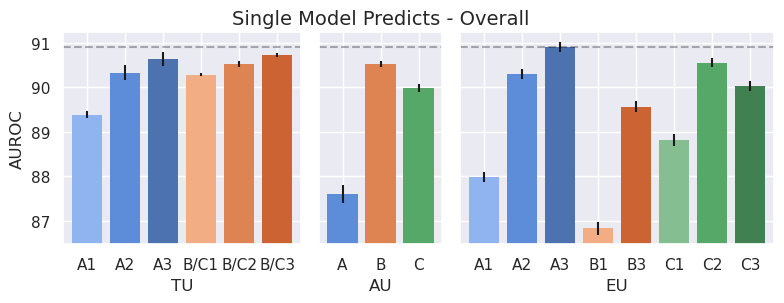

In [85]:
preds = [torch.argmax(p[:, :, 0], dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

data = data.mean(dim=0)

plot(data, "Single Model Predicts - Overall", f"misc_{method}_{model}_{metric.__name__}_single_overall")

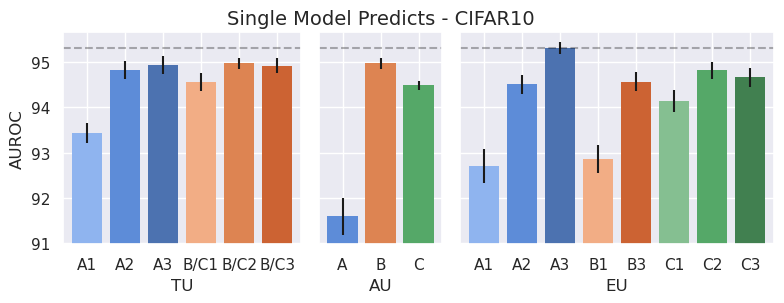

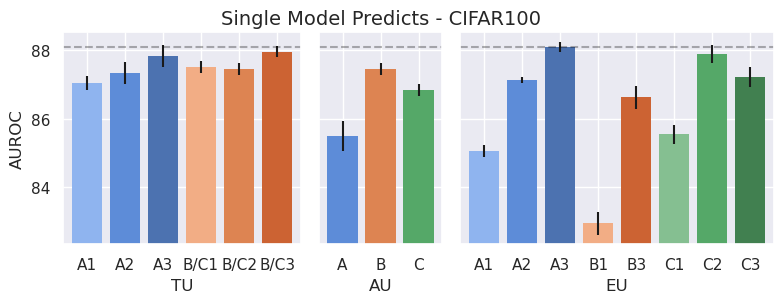

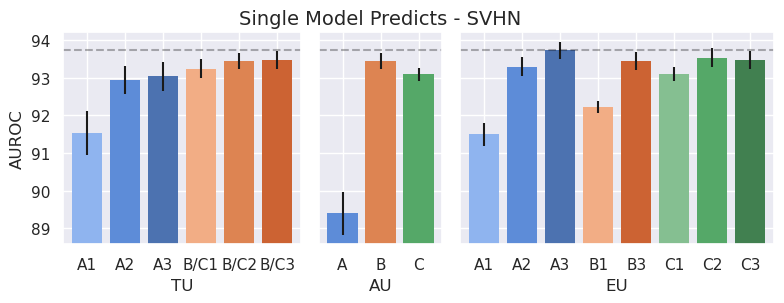

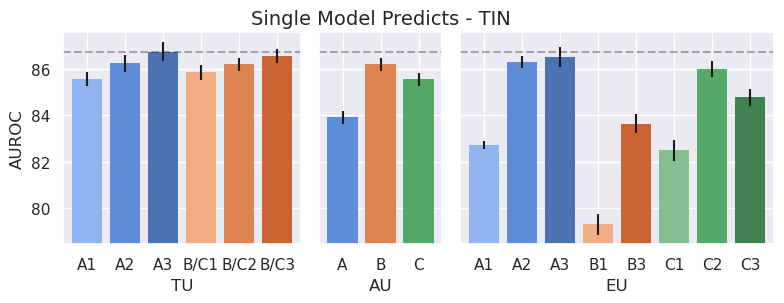

In [86]:
preds = [torch.argmax(p[:, :, 0], dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

for i in range(len(dataset_names)):
    plot(data[i], f"Single Model Predicts - {dataset_names[i].upper()}") #, f"misc_det_{method}_{model}_{metric.__name__}_single_{dataset_names[i]}")

## Average Model

torch.Size([4, 26, 5])


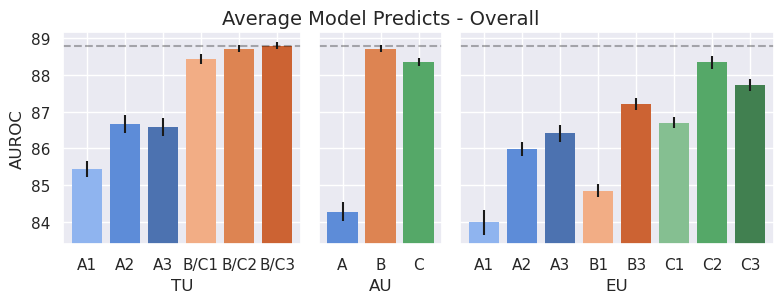

In [87]:
preds = [torch.argmax(torch.mean(p, dim=2), dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

data = data.mean(dim=0)

plot(data, "Average Model Predicts - Overall", f"misc_{method}_{model}_{metric.__name__}_average_overall")

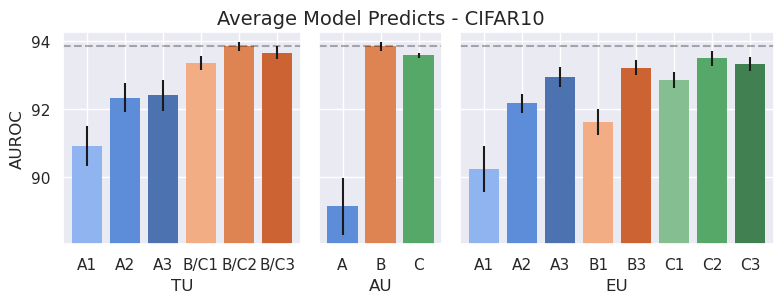

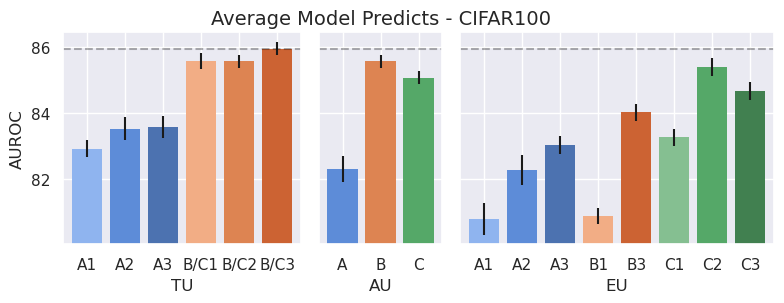

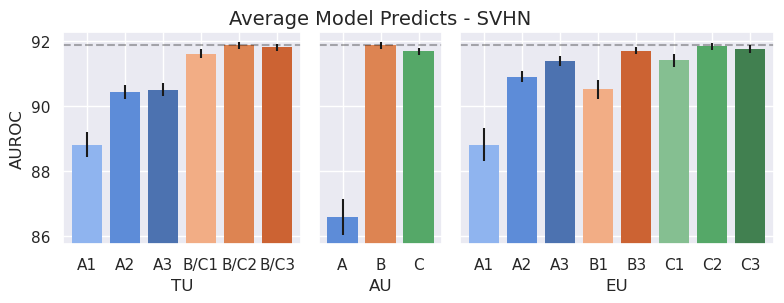

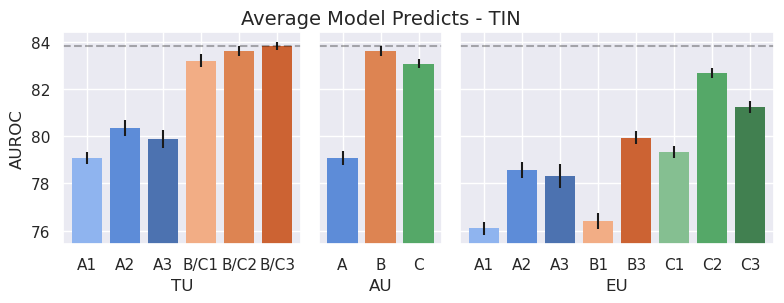

In [88]:
preds = [torch.argmax(torch.mean(p, dim=2), dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

for i in range(len(dataset_names)):
    plot(data[i], f"Average Model Predicts - {dataset_names[i].upper()}") #, f"misc_det_{method}_{model}_{metric.__name__}_average_{dataset_names[i]}")

## According to Posterior

torch.Size([4, 26, 5])


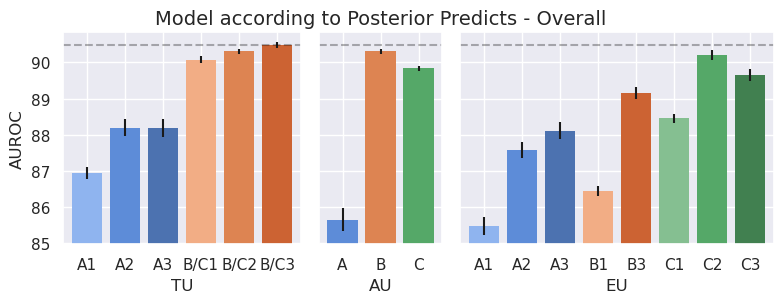

In [89]:
indices = []
for p in probits:
    indices.append(torch.randint(0, p.shape[2], (p.shape[0], p.shape[1], 1, p.shape[3])))

preds = [torch.argmax(torch.gather(p, dim=2, index=indices[i]).squeeze(2), dim=-1) for i, p in enumerate(probits)]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

data = data.mean(dim=0)

plot(data, "Model according to Posterior Predicts - Overall", f"misc_{method}_{model}_{metric.__name__}_posterior_overall")

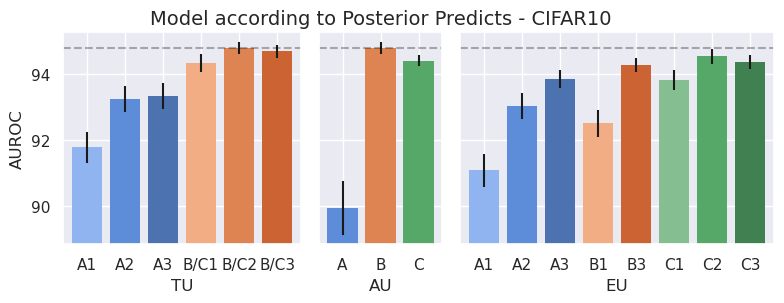

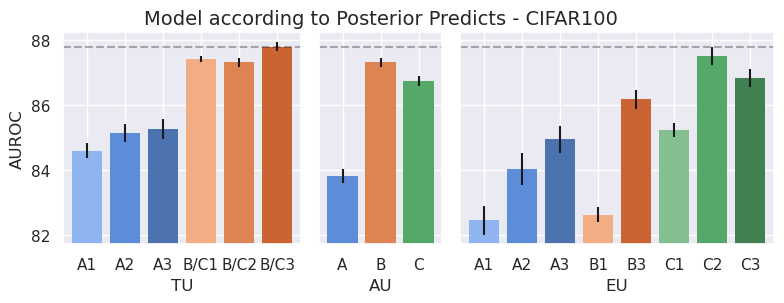

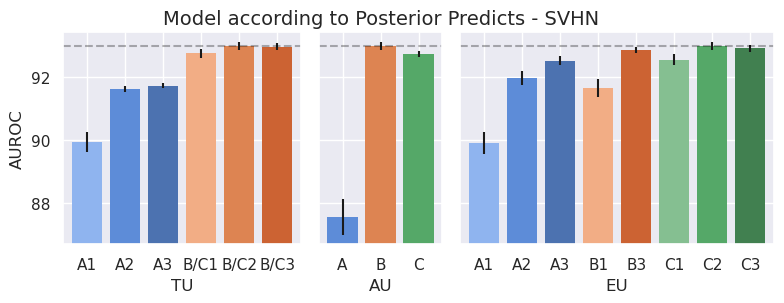

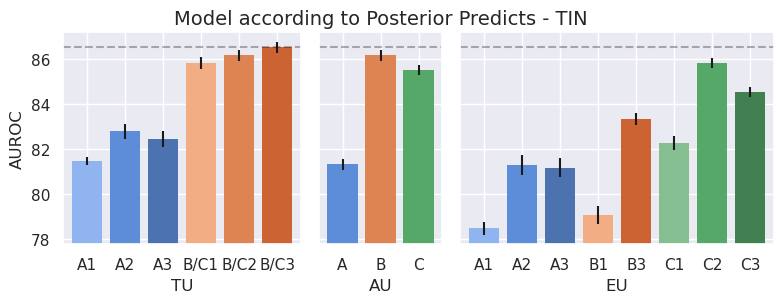

In [90]:
preds = [torch.argmax(torch.gather(p, dim=2, index=indices[i]).squeeze(2), dim=-1) for i, p in enumerate(probits)]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

for i in range(len(dataset_names)):
    plot(data[i], f"Model according to Posterior Predicts - {dataset_names[i].upper()}") #, f"misc_det_{method}_{model}_{metric.__name__}_posterior_{dataset_names[i]}")